In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/data-pkl/df.pkl
/kaggle/input/sentimental-analysis-for-tweets/sentiment_tweets3.csv


In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import nltk
import re 
from wordcloud import WordCloud
import seaborn as seb
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import PorterStemmer
import pickle
import csv
import seaborn as sns
import string
import nltk
import collections       
import matplotlib
import scikitplot as skplt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures , TrigramAssocMeasures
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models, similarities
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
import pyLDAvis.gensim
from collections import OrderedDict
from nltk.collocations import BigramCollocationFinder 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
from collections import Counter
from wordcloud import WordCloud

%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [7]:
from tensorflow import keras as keras
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

In [6]:
stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 
stop_words

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',


Read Tweets

In [9]:
data = pd.read_csv('../input/sentimental-analysis-for-tweets/sentiment_tweets3.csv', encoding='latin1', index_col=False)\
            .rename(columns={'message to examine': 'OriginalTweet', 'label (depression result)': 'Sentiment'})

In [10]:
data.columns

Index(['Index', 'OriginalTweet', 'Sentiment'], dtype='object')

In [11]:
data= data.drop(columns=['Index'])

In [12]:
data.head()

,OriginalTweet,Sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


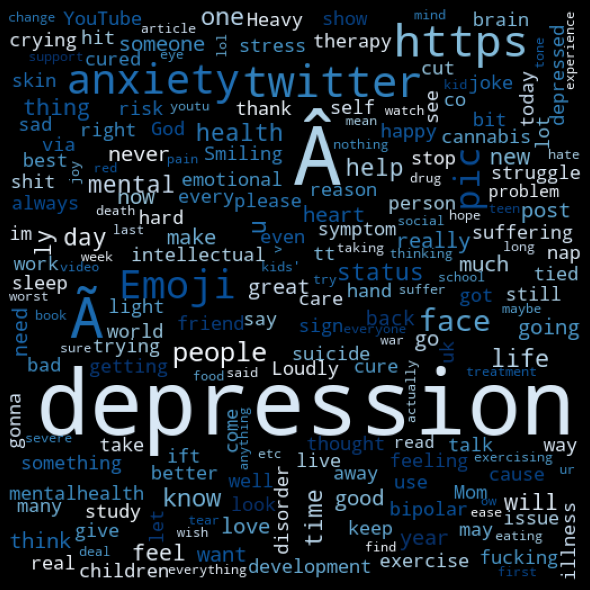

In [13]:
depressive_words = ' '.join(list(data[data['Sentiment'] == 1]['OriginalTweet']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

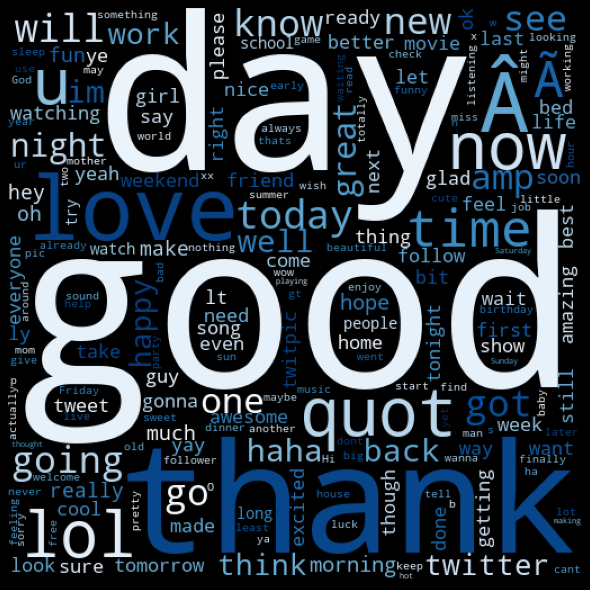

In [14]:
positive_words = ' '.join(list(data[data['Sentiment'] == 0]['OriginalTweet']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [15]:
class_df = data.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Sentiment,OriginalTweet
0,0,8000
1,1,2314


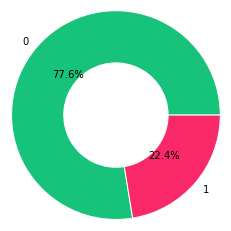

In [16]:
percent_class=class_df.OriginalTweet
class_label= class_df.Sentiment
colors = ['#17C37B','#F92969','#FACA0C', '#FF3B49', '#26DE81']
my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=class_label,colors=colors,autopct="%.1f%%")
plt.setp(my_pie, width=0.6, edgecolor='white') 
plt.show()

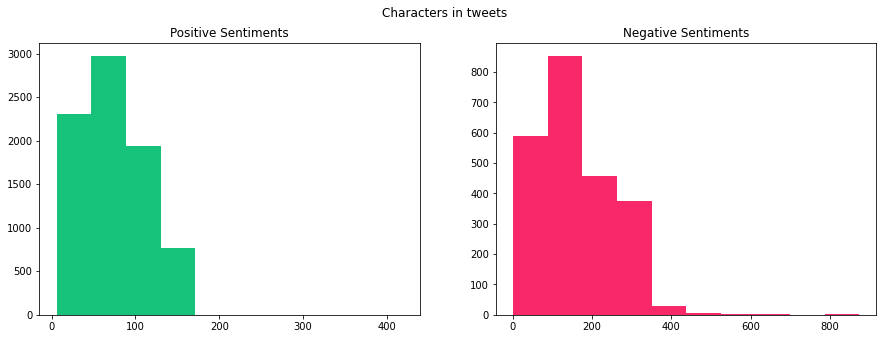

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
tweet_len=data[data['Sentiment']==0]['OriginalTweet'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=data[data['Sentiment']==1]['OriginalTweet'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

In [24]:
data.drop_duplicates()

,OriginalTweet,Sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [25]:
data['cleaned_tweet']  = data['OriginalTweet'].str.lower()
data['cleaned_tweet'].head()

0    just had a real good moment. i missssssssss hi...
1           is reading manga  http://plurk.com/p/mzp1e
2    @comeagainjen http://twitpic.com/2y2lx - http:...
3    @lapcat need to send 'em to my accountant tomo...
4        add me on myspace!!!  myspace.com/lookthunder
Name: cleaned_tweet, dtype: object

In [26]:
#removing punctuation, creating a new column called 'text_punct]'
data['cleaned_tweet'] = data['cleaned_tweet'].str.replace('[^\w\s]','')
data['cleaned_tweet'].head()

0    just had a real good moment i missssssssss him...
1                 is reading manga  httpplurkcompmzp1e
2    comeagainjen httptwitpiccom2y2lx  httpwwwyoutu...
3    lapcat need to send em to my accountant tomorr...
4             add me on myspace  myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [27]:
# Applying the stopwords to 'text_punct' and store into 'text_stop'
data["cleaned_tweet"] = data["cleaned_tweet"].apply(lambda x: " ".join([w for w in str(x).split() if not w in stop_words]))
data["cleaned_tweet"].head()

0                        real good moment missssssssss
1                     reading manga httpplurkcompmzp1e
2    comeagainjen httptwitpiccom2y2lx httpwwwyoutub...
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [28]:
# Function to remove emoji.
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)


data["cleaned_tweet"] = data["cleaned_tweet"].apply(lambda x: remove_emoji(str(x)))
data["cleaned_tweet"].head()

0                        real good moment missssssssss
1                     reading manga httpplurkcompmzp1e
2    comeagainjen httptwitpiccom2y2lx httpwwwyoutub...
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [31]:
# Function for removing emoticons
def remove_emoticons(tweet):
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
        cleaned_tweet = emoji_pattern.sub(r'',tweet)
        return cleaned_tweet

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_emoticons)
data["cleaned_tweet"].head()

0                        real good moment missssssssss
1                     reading manga httpplurkcompmzp1e
2    comeagainjen httptwitpiccom2y2lx httpwwwyoutub...
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [32]:
# Function for url's
# def remove_urls(tweet):
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     return url_pattern.sub(r'', tweet)

# def remove_urls(tweet):
#     cleaned_tweet = re.sub(r"(https|http|ftp)?://\S*.((\S*\S*)|(\S*))",'', tweet)
#     return cleaned_tweet

# def remove_urls(data):
#     return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

def remove_urls(tweet):
    return re.sub(r'http[^\s]*','',tweet)


data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_urls)
data["cleaned_tweet"].head()

0                        real good moment missssssssss
1                                       reading manga 
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [37]:
from bs4 import BeautifulSoup

In [38]:
from datetime import datetime

In [39]:
#Function for removing html
def remove_html(tweet):
    return BeautifulSoup(tweet, "lxml").text

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_html)
data["cleaned_tweet"].head()

0                        real good moment missssssssss
1                                       reading manga 
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [40]:
def remove_mintions(tweet):
    cleaned_tweet = re.sub(r"@\S+",'',tweet)
    return cleaned_tweet

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_mintions)
data["cleaned_tweet"].head()

0                        real good moment missssssssss
1                                       reading manga 
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: cleaned_tweet, dtype: object

In [41]:
def remove_images(tweet):
    cleaned_tweet = re.sub(r"pic\.twitter\.com/\S+",'', tweet)
    cleaned_tweet = re.sub("\w+(\.png|\.jpg|\.gif|\.jpeg)", " ", cleaned_tweet)
    return cleaned_tweet

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_images)
data["cleaned_tweet"].head(10)

0                        real good moment missssssssss
1                                       reading manga 
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
5                            sleepy good times tonight
6           silkcharm nbn said fiber home mean regular
7                       23 24ãââ½c possible today nice
8                       nite twitterville workout ciao
9                   dananner night darlin sweet dreams
Name: cleaned_tweet, dtype: object

In [42]:
def remove_duplicated_chars(tweet):
    return re.sub(r'(.)\1+', r'\1\1', tweet)  # keep 2 repeat

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_duplicated_chars)
data["cleaned_tweet"].head(10)

0                                real good moment miss
1                                       reading manga 
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
5                            sleepy good times tonight
6           silkcharm nbn said fiber home mean regular
7                       23 24ãââ½c possible today nice
8                       nite twitterville workout ciao
9                   dananner night darlin sweet dreams
Name: cleaned_tweet, dtype: object

In [43]:
def remove_tweet_digits(tweet):
    cleaned_tweet = re.sub(r'[d]+', r'', tweet)
    cleaned_tweet = re.sub(r'[0-9]*','',tweet)
    cleaned_tweet = re.sub(r'([0-9]*\-[0-9]*)*', '', cleaned_tweet)
    return cleaned_tweet 

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_tweet_digits)
data["cleaned_tweet"].head(10)

0                                real good moment miss
1                                       reading manga 
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
5                            sleepy good times tonight
6           silkcharm nbn said fiber home mean regular
7                            ãââ½c possible today nice
8                       nite twitterville workout ciao
9                   dananner night darlin sweet dreams
Name: cleaned_tweet, dtype: object

In [45]:
def remove_chars(tweet):
    cleaned_tweet = re.sub(r'[/(){}\[\]\|]', '', tweet)
    cleaned_tweet = re.sub(r'[!$%^?&*><]', '', cleaned_tweet )
    cleaned_tweet = re.sub(r'[\'\"،—.,;+-=]', '', cleaned_tweet )
    cleaned_tweet = re.sub(r'[\n]', '', cleaned_tweet ) # removing \n
    cleaned_tweet =re.sub(r"\s+",' ',cleaned_tweet) # remove_extra_white_space
    return cleaned_tweet

data["cleaned_tweet"] = data["cleaned_tweet"].apply(remove_chars)
data["cleaned_tweet"].head(10)

0                                real good moment miss
1                                       reading manga 
2                                        comeagainjen 
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
5                            sleepy good times tonight
6           silkcharm nbn said fiber home mean regular
7                            ãââ½c possible today nice
8                       nite twitterville workout ciao
9                   dananner night darlin sweet dreams
Name: cleaned_tweet, dtype: object

In [46]:
pip install language_tool_python

Note: you may need to restart the kernel to use updated packages.


In [47]:
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://www.languagetool.org/dev
"""
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [ ]:
data['corrected'] = data.apply(lambda l: tool.correct(l['cleaned_tweet']), axis=1)

In [ ]:
data['corrected']

In [ ]:
sents = []
tokens = []
lemma = []
pos = []
ner = []


nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for tweet in nlp.pipe(data['corrected'], batch_size=100, n_process=3):
    if tweet.is_parsed:
        tokens.append([e.text for e in tweet])
        sents.append([sent.text.strip() for sent in tweet.sents])
        pos.append([e.pos_ for e in tweet])
        ner.append([e.text for e in tweet.ents])
        lemma.append([n.lemma_ for n in tweet])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

data['tokens'] = tokens
data['lemma'] = lemma
data['pos'] = pos
data['sents'] = sents
data['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

In [ ]:
data.head()

In [ ]:
# Lemmatized essays re-joined (list to essay)
data['l_essay'] = data['lemma'].apply(' '.join)

In [ ]:
data.head()

In [9]:
# data.to_pickle('df.pkl')
data = pd.read_pickle('../input/data-pkl/df.pkl')

In [49]:
def find_ngrams(data):
    class_text = " ".join(data.tolist())
    tokens= TweetTokenizer().tokenize(class_text)
  #unigram
    print('uni_gram -> HighFreq:')
    unigram_freq = nltk.ngrams(tokens, 1)
    unigram_freq=nltk.FreqDist(unigram_freq)
    print(unigram_freq.most_common()[:10])
    print('uni_gram -> LowFreq:')
    print(unigram_freq.most_common()[-10:])
    print('\n')
  
 #bigram
    print('bi_gram -> HighFreq:')
    bigram_freq = nltk.ngrams(tokens, 2)
    bigram_freq=nltk.FreqDist(bigram_freq)
    print(bigram_freq.most_common()[:10])
    print('bi_gram -> LowFreq:')
    print(bigram_freq.most_common()[-10:])
    print('\n')
    
  #trigram
    print('tri_gram -> HighFreq:')
    trigram_freq = nltk.ngrams(tokens, 3)
    trigram_freq=nltk.FreqDist(trigram_freq)
    print(trigram_freq.most_common()[:10])
    print('tri_gram -> LowFreq:')
    print(trigram_freq.most_common()[-10:])

In [51]:
find_ngrams(data['corrected'])

uni_gram -> HighFreq:
[(('depression',), 2189), (("I'm",), 807), (('good',), 613), (('love',), 540), (('like',), 529), (('day',), 529), (('AAA',), 476), (("don't",), 408), (('going',), 392), (('lol',), 391)]
uni_gram -> LowFreq:
[(('rebelliousraggs',), 1), (('sethshruti',), 1), (('Ra_bis',), 1), (('Bharat',), 1), (('provoking',), 1), (('Sufferers',), 1), (('persistent',), 1), (('nagging',), 1), (('moo',), 1), (('succumbs',), 1)]


bi_gram -> HighFreq:
[(('anxiety', 'depression'), 139), (('depression', 'anxiety'), 139), (('mental', 'health'), 111), (("I'm", 'going'), 88), (("can't", 'wait'), 85), (('depression', 'AAA'), 84), (('going', 'to'), 81), (('want', 'to'), 67), (("don't", 'know'), 58), (('Good', 'morning'), 54)]
bi_gram -> LowFreq:
[(('stressing', 'people'), 1), (('deserve', 'Depression'), 1), (('Depression', 'succumbs'), 1), (('succumbs', 'brain'), 1), (('brain', 'makes'), 1), (('like', "you'll"), 1), (("you'll", 'Ketamine'), 1), (('health', "don't"), 1), (('mistake', 'bad'), 1

In [52]:
# Checking the first 10 most frequent words
from collections import Counter
cnt = Counter()
for text in data["corrected"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(10)

[('depression', 2189),
 ("I'm", 807),
 ('good', 613),
 ('love', 540),
 ('like', 529),
 ('day', 529),
 ('AAA', 447),
 ("don't", 408),
 ('going', 392),
 ('lol', 391)]

In [53]:
cnt.most_common()[-10:]

[('rebelliousraggs', 1),
 ('sethshruti', 1),
 ('Ra_bis', 1),
 ('Bharat', 1),
 ('provoking', 1),
 ('Sufferers', 1),
 ('persistent', 1),
 ('nagging', 1),
 ('moo', 1),
 ('succumbs', 1)]

In [54]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)

In [55]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
data.head()

,OriginalTweet,Sentiment,cleaned_tweet,corrected,tokens,lemma,pos,sents,ner,l_essay
0,just had a real good moment. i missssssssss hi...,0,real good moment miss,Real good moment miss,"[Real, good, moment, miss]","[real, good, moment, miss]","[ADV, ADJ, NOUN, VERB]",[Real good moment miss],[],real good moment miss
1,is reading manga http://plurk.com/p/mzp1e,0,reading manga,Reading manga,"[Reading, manga]","[read, manga]","[VERB, NOUN]",[Reading manga],[manga],read manga
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,comeagainjen,Comeagainjen,[Comeagainjen],[Comeagainjen],[PROPN],[Comeagainjen],[],Comeagainjen
3,@lapcat Need to send 'em to my accountant tomo...,0,lapcat need send em accountant tomorrow oddly ...,Lapcat need to send me accountant tomorrow odd...,"[Lapcat, need, to, send, me, accountant, tomor...","[Lapcat, need, to, send, I, accountant, tomorr...","[PROPN, VERB, PART, VERB, PRON, NOUN, NOUN, AD...",[Lapcat need to send me accountant tomorrow od...,[Lapcat],Lapcat need to send I accountant tomorrow oddl...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add myspace myspacecomlookthunder,Add MySpace myspacecomlookthunder,"[Add, MySpace, myspacecomlookthunder]","[Add, MySpace, myspacecomlookthunder]","[PROPN, PROPN, VERB]",[Add MySpace myspacecomlookthunder],[Add MySpace],Add MySpace myspacecomlookthunder


In [12]:
texts=data['l_essay']

In [15]:
texts

0                                    real good moment miss
1                                               read manga
2                                             Comeagainjen
3        Lapcat need to send I accountant tomorrow oddl...
4                        Add MySpace myspacecomlookthunder
                               ...                        
10309    depression g hero moo dim stress people do not...
10310     depression succumb brain make feel like you will
10311    ketamine nasal spray show promise depression s...
10312                 do not mistake bad day depression em
10313                                                     
Name: l_essay, Length: 10314, dtype: object

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
y=data['Sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=110 ,stratify=y)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# use a BOW model to vectorize the sentences. 
def bow_features(data):
    count_vectorizer = CountVectorizer(analyzer= 'word', stop_words='english',ngram_range=(1, 3))
    emb = count_vectorizer.fit_transform(data)
    return emb,count_vectorizer

In [15]:
X_train_bag, count_vectorizer =  bow_features(X_train)
X_test_bag = count_vectorizer.transform(X_test)

In [17]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1']
c_values = [0.01, 0.1, 0.5, 1.0, 5.0,10]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train_bag, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997980 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.997261 (0.002385) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.997261 (0.002385) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.997630 (0.002273) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'lbfgs'}
0.991357 (0.004981) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.997543 (0.002215) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.997543 (0.002215) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.997980 (0.002038) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'lbfgs'}
0.991357 (0.004981) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.997718 (0.00

In [32]:
lr_model=LogisticRegression(C=1000, penalty='l2', solver='liblinear',class_weight='balanced')
lr_model_result = lr_model.fit(X_train_bag, y_train)

In [23]:
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    acc_score=accuracy_score(y_true=y_true, y_pred=y_pred)
    return (f'accuracy_score:\n {acc_score}\n\nConfusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [33]:
y_pred= lr_model.predict(X_test_bag)

In [35]:
print(report(y_test, y_pred, lr_model.classes_ ))

accuracy_score:
 0.9621909840038778

Confusion Matrix:
      0    1
0  1543   57
1    21  442

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1600
           1       0.89      0.95      0.92       463

    accuracy                           0.96      2063
   macro avg       0.94      0.96      0.95      2063
weighted avg       0.96      0.96      0.96      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

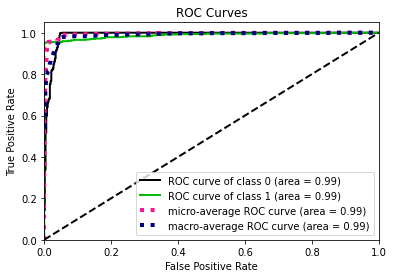

In [36]:
skplt.metrics.plot_roc(y_test,lr_model.predict_proba(X_test_bag))

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(min_df=7, max_df=0.7, ngram_range=(1, 3))
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [138]:
classifier_tfidf = lr_model.fit(X_train_tfidf, y_train)

In [139]:
y_pred = classifier_tfidf.predict(X_test_tfidf)

In [140]:
print(report(y_test, y_pred, classifier_tfidf .classes_))

accuracy_score:
 0.9903053805138148

Confusion Matrix:
      0    1
0  1585   15
1     5  458

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1600
           1       0.97      0.99      0.98       463

    accuracy                           0.99      2063
   macro avg       0.98      0.99      0.99      2063
weighted avg       0.99      0.99      0.99      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

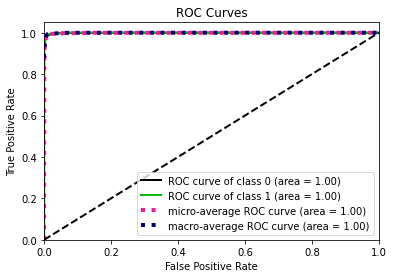

In [144]:
skplt.metrics.plot_roc(y_test,classifier_tfidf.predict_proba(X_test_tfidf))

In [55]:
# ridge classifier
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train_bag, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996438 using {'alpha': 0.3}
0.996064 (0.003116) with: {'alpha': 0.1}
0.996398 (0.002984) with: {'alpha': 0.2}
0.996438 (0.002989) with: {'alpha': 0.3}
0.996433 (0.003014) with: {'alpha': 0.4}
0.996395 (0.003037) with: {'alpha': 0.5}
0.996367 (0.003063) with: {'alpha': 0.6}


In [157]:
Ridge_model = RidgeClassifier(alpha=100)
y_test =Ridge_model.fit(X_train_bag, y_train).predict(X_test_bag)

In [158]:
print(report(y_test, y_pred, Ridge_model.classes_ ))

accuracy_score:
 0.9907901114881241

Confusion Matrix:
      0    1
0  1586   15
1     4  458

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1601
           1       0.97      0.99      0.98       462

    accuracy                           0.99      2063
   macro avg       0.98      0.99      0.99      2063
weighted avg       0.99      0.99      0.99      2063



In [25]:
# ridge classifier

model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train_tfidf, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.995697 using {'alpha': 1.0}
0.994468 (0.004053) with: {'alpha': 0.1}
0.994693 (0.003957) with: {'alpha': 0.2}
0.994872 (0.003897) with: {'alpha': 0.3}
0.995027 (0.003840) with: {'alpha': 0.4}
0.995169 (0.003763) with: {'alpha': 0.5}
0.995302 (0.003690) with: {'alpha': 0.6}
0.995435 (0.003583) with: {'alpha': 0.7}
0.995540 (0.003505) with: {'alpha': 0.8}
0.995622 (0.003455) with: {'alpha': 0.9}
0.995697 (0.003408) with: {'alpha': 1.0}


In [168]:
Ridge_model = RidgeClassifier(alpha=1.0)
y_pred =Ridge_model.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

In [169]:
print(report(y_test, y_pred, Ridge_model.classes_ ))

accuracy_score:
 0.9810954920019389

Confusion Matrix:
      0    1
0  1600    1
1    38  424

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1601
           1       1.00      0.92      0.96       462

    accuracy                           0.98      2063
   macro avg       0.99      0.96      0.97      2063
weighted avg       0.98      0.98      0.98      2063



In [170]:
from sklearn.naive_bayes import MultinomialNB
import math

In [72]:
grid_params ={'alpha':[10**x for x in range(-4,4)]}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

MultinomialNB_model = GridSearchCV(MultinomialNB(),grid_params,
                     scoring = 'roc_auc', cv=10,n_jobs=-1, return_train_score=True)
grid_result = MultinomialNB_model.fit(X_train_bag, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997508 using {'alpha': 1}
0.990597 (0.003913) with: {'alpha': 0.0001}
0.992857 (0.002996) with: {'alpha': 0.001}
0.995501 (0.002231) with: {'alpha': 0.01}
0.997079 (0.001585) with: {'alpha': 0.1}
0.997508 (0.002057) with: {'alpha': 1}
0.991975 (0.004606) with: {'alpha': 10}
0.989679 (0.004667) with: {'alpha': 100}
0.995301 (0.002171) with: {'alpha': 1000}


In [191]:
MultinomialNB_model = MultinomialNB(alpha=0.001)
y_pred =MultinomialNB_model.fit(X_train_bag, y_train).predict(X_test_bag)
print(report(y_test, y_pred, MultinomialNB_model.classes_ ))

accuracy_score:
 0.9457101308773631

Confusion Matrix:
      0    1
0  1503   98
1    14  448

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1601
           1       0.82      0.97      0.89       462

    accuracy                           0.95      2063
   macro avg       0.91      0.95      0.93      2063
weighted avg       0.95      0.95      0.95      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

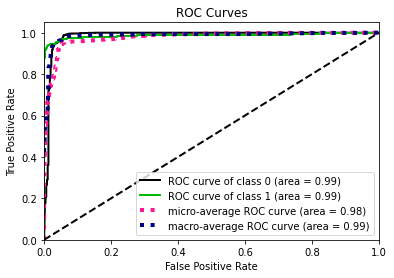

In [192]:
skplt.metrics.plot_roc(y_test, MultinomialNB_model.predict_proba(X_test_bag))

In [193]:
y_pred =MultinomialNB_model.fit(X_train_tfidf, y_train).predict(X_test_tfidf)
print(report(y_test, y_pred, MultinomialNB_model.classes_ ))

accuracy_score:
 0.9694619486185168

Confusion Matrix:
      0    1
0  1576   25
1    38  424

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1601
           1       0.94      0.92      0.93       462

    accuracy                           0.97      2063
   macro avg       0.96      0.95      0.96      2063
weighted avg       0.97      0.97      0.97      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

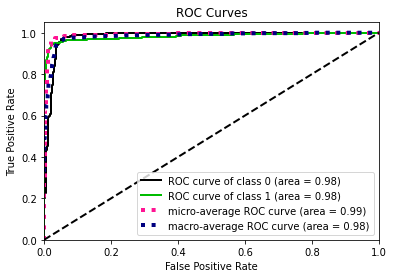

In [194]:
skplt.metrics.plot_roc(y_test, MultinomialNB_model.predict_proba(X_test_tfidf))

In [80]:
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
grid_params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

SGDClassifier_model = GridSearchCV(SGDClassifier(), grid_params,
                     scoring = 'roc_auc', cv=10,n_jobs=-1, return_train_score=True)

grid_result = SGDClassifier_model.fit(X_train_bag, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.998150 using {'alpha': 0.01, 'penalty': 'l2'}
0.994492 (0.002669) with: {'alpha': 0.0001, 'penalty': 'l1'}
0.995255 (0.002169) with: {'alpha': 0.0001, 'penalty': 'l2'}
0.992291 (0.002536) with: {'alpha': 0.001, 'penalty': 'l1'}
0.994135 (0.003315) with: {'alpha': 0.001, 'penalty': 'l2'}
0.991626 (0.002818) with: {'alpha': 0.01, 'penalty': 'l1'}
0.998150 (0.001332) with: {'alpha': 0.01, 'penalty': 'l2'}
0.991359 (0.003141) with: {'alpha': 0.1, 'penalty': 'l1'}
0.995961 (0.002613) with: {'alpha': 0.1, 'penalty': 'l2'}
0.500000 (0.000000) with: {'alpha': 1, 'penalty': 'l1'}
0.996127 (0.002365) with: {'alpha': 1, 'penalty': 'l2'}
0.500000 (0.000000) with: {'alpha': 10, 'penalty': 'l1'}
0.996159 (0.002384) with: {'alpha': 10, 'penalty': 'l2'}
0.500000 (0.000000) with: {'alpha': 100, 'penalty': 'l1'}
0.996154 (0.002383) with: {'alpha': 100, 'penalty': 'l2'}
0.500000 (0.000000) with: {'alpha': 1000, 'penalty': 'l1'}
0.996155 (0.002386) with: {'alpha': 1000, 'penalty': 'l2'}


In [252]:
from sklearn.calibration import CalibratedClassifierCV
SGDClassifier_model=  SGDClassifier(loss='hinge',class_weight='balanced', penalty='l1',alpha=0.000001)
clf =SGDClassifier_model.fit(X_train_bag, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
y_pred=calibrator.fit(X_train_bag, y_train).predict(X_test_bag)
print(report(y_test, y_pred, calibrator.classes_ ))

accuracy_score:
 0.9752787203102278

Confusion Matrix:
      0    1
0  1601    0
1    51  411

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1601
           1       1.00      0.89      0.94       462

    accuracy                           0.98      2063
   macro avg       0.98      0.94      0.96      2063
weighted avg       0.98      0.98      0.97      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

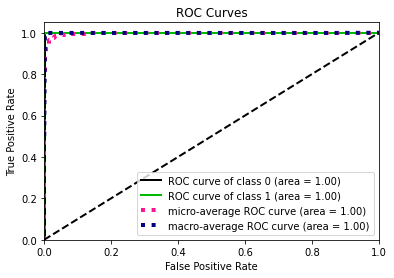

In [253]:
skplt.metrics.plot_roc(y_test, calibrator.predict_proba(X_test_bag))

In [254]:
clf =SGDClassifier_model.fit(X_train_tfidf, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
y_pred=calibrator.fit(X_train_tfidf, y_train).predict(X_test_tfidf)
print(report(y_test, y_pred, calibrator.classes_ ))

accuracy_score:
 0.9835191468734852

Confusion Matrix:
      0    1
0  1600    1
1    33  429

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1601
           1       1.00      0.93      0.96       462

    accuracy                           0.98      2063
   macro avg       0.99      0.96      0.98      2063
weighted avg       0.98      0.98      0.98      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

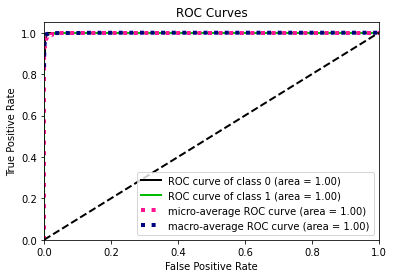

In [255]:
skplt.metrics.plot_roc(y_test, calibrator.predict_proba(X_test_tfidf))

In [257]:
from sklearn.svm import SVC
svc_model = SVC(C= 100, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)

In [258]:
y_pred=svc_model.fit(X_train_bag, y_train).predict(X_test_bag)

In [259]:
print(report(y_test, y_pred, svc_model.classes_))

accuracy_score:
 0.8734852157052836

Confusion Matrix:
      0    1
0  1375  226
1    35  427

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      1601
           1       0.65      0.92      0.77       462

    accuracy                           0.87      2063
   macro avg       0.81      0.89      0.84      2063
weighted avg       0.90      0.87      0.88      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

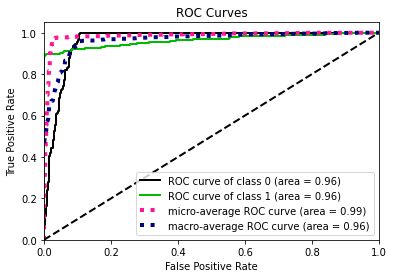

In [261]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_bag))

KeyboardInterrupt: 

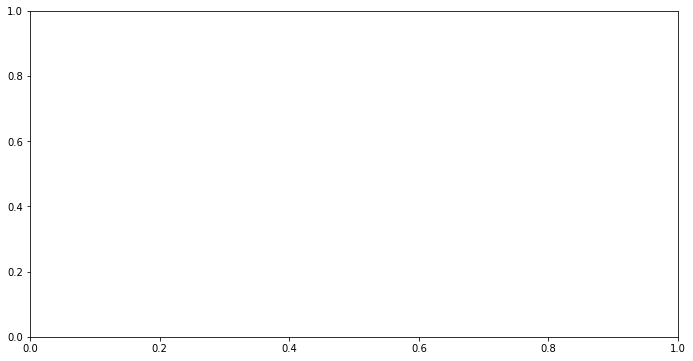

In [263]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(left=0.1, right=1, wspace=1)

N, train_lc, val_lc = learning_curve(svc_model,
                                     X_train_bag, y_train, cv=5,
                                     train_sizes=np.linspace(0.1, 1, 30))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
             color='gray', linestyle='dashed')


ax.set_xlabel('training size')
ax.set_ylabel('score')
ax.legend(loc='best')

In [282]:
y_pred=svc_model.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

In [283]:
print(report(y_test, y_pred, svc_model.classes_))

accuracy_score:
 0.9917595734367426

Confusion Matrix:
      0    1
0  1588   13
1     4  458

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1601
           1       0.97      0.99      0.98       462

    accuracy                           0.99      2063
   macro avg       0.98      0.99      0.99      2063
weighted avg       0.99      0.99      0.99      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

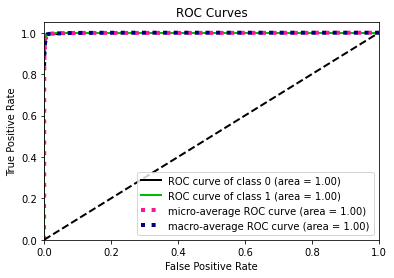

In [284]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_tfidf))

In [409]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train_bag, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50,
                       random_state=3)

In [410]:
y_pred=rf_model.predict(X_test_bag)

In [411]:
print(report(y_test, y_pred, rf_model.classes_))

accuracy_score:
 0.883664566165778

Confusion Matrix:
      0    1
0  1564   37
1   203  259

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1601
           1       0.88      0.56      0.68       462

    accuracy                           0.88      2063
   macro avg       0.88      0.77      0.81      2063
weighted avg       0.88      0.88      0.87      2063



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

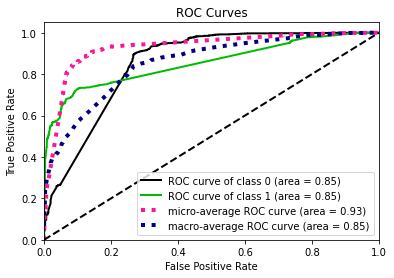

In [412]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test_bag))